# EDA & Preprocessing for Regression Dataset

## Setup & Imports

In [6]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [10]:
import numpy as np
import pandas as pd

from bagging_boosting_stacking_study.data.loaders import load_dataset
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import seaborn as sns

ModuleNotFoundError: No module named 'bagging_boosting_stacking_study'

## 1. Load Data

In [29]:
df = load_dataset("energy_efficiency")
SEED = 313230

## 2. Initial Data Inspection

- Summary of dataset dimensions (number of rows and columns). For example, "The dataset contains 10,000 rows and 15 columns."
- Overview of each column’s data type (numeric, categorical, datetime), and counts of non-null entries. For instance, "Column A is numeric with 95% non-null values."
- A tally of missing values, with a quick interpretation: "Column X has 12% missing—this will require imputation or removal."
- Any immediate red flags (e.g., "Column Y has all-zero values," "Column Z has only one unique value," or "There are 50 duplicated rows").

In [8]:
# Summary of dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Overview of each column’s data type and counts of non-null entries
print("\nDataFrame info:")
df.info()

# Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    display(missing_values[missing_values > 0])

# Check for duplicated rows
duplicated_rows = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicated_rows}")

Dataset contains 768 rows and 10 columns.

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative Compactness       768 non-null    float64
 1   Surface Area               768 non-null    float64
 2   Wall Area                  768 non-null    float64
 3   Roof Area                  768 non-null    float64
 4   Overall Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing Area               768 non-null    float64
 7   Glazing Area Distribution  768 non-null    int64  
 8   Heating Load               768 non-null    float64
 9   Cooling Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB

Missing Values:
No missing values found.

Number of duplicated rows: 0


In [15]:
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


## 3. Univariate Descriptions

- A table of descriptive statistics for each numeric column: mean, standard deviation, minimum, maximum, and quartiles.
- Highlights of features whose distributions are heavily skewed or have extreme outliers. Consider using histograms or box plots to visualize these distributions.
- A narrative on the target variable: its range, central tendency, and whether it’s approximately bell-shaped, heavy-tailed, or multimodal.
- Notes on any categorical or discrete columns: number of categories, imbalanced levels, or rare values. For example, "Category A has 90% of the data, while Category B has only 1%."

In [9]:
numeric_df = df.select_dtypes(include="number")
 
desc_stats = pd.DataFrame({
    "mean": numeric_df.mean(),
    "std": numeric_df.std(),
    "min": numeric_df.min(),
    "25%": numeric_df.quantile(0.25),
    "50% (median)": numeric_df.median(),
    "75%": numeric_df.quantile(0.75),
    "max": numeric_df.max()})
 
print(desc_stats.round(2))

                             mean    std     min     25%  50% (median)  \
Relative Compactness         0.76   0.11    0.62    0.68          0.75   
Surface Area               671.71  88.09  514.50  606.38        673.75   
Wall Area                  318.50  43.63  245.00  294.00        318.50   
Roof Area                  176.60  45.17  110.25  140.88        183.75   
Overall Height               5.25   1.75    3.50    3.50          5.25   
Orientation                  3.50   1.12    2.00    2.75          3.50   
Glazing Area                 0.23   0.13    0.00    0.10          0.25   
Glazing Area Distribution    2.81   1.55    0.00    1.75          3.00   
Heating Load                22.31  10.09    6.01   12.99         18.95   
Cooling Load                24.59   9.51   10.90   15.62         22.08   

                              75%     max  
Relative Compactness         0.83    0.98  
Surface Area               741.12  808.50  
Wall Area                  343.00  416.50  
Roof Area

In [10]:
numeric_df = df.select_dtypes(include="number")
 
# Skewness
skewness = numeric_df.skew()
 
# Outlier stats
iqr_outliers = {}
z_outliers = {}
outlier_indices = {}
 
for col in numeric_df.columns:
    series = numeric_df[col]
   
    # IQR-based
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    iqr_bounds = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    iqr_mask = (series < iqr_bounds[0]) | (series > iqr_bounds[1])
    iqr_outliers[col] = iqr_mask.sum()
 
    # Z-score-based
    z_scores = (series - series.mean()) / series.std()
    z_mask = np.abs(z_scores) > 3
    z_outliers[col] = z_mask.sum()
 
    # Save indices
    outlier_indices[col] = {
        "iqr": series.index[iqr_mask].tolist(),
        "z": series.index[z_mask].tolist()
    }
 
# DataFrame
summary = pd.DataFrame({
    "Skewness": skewness.round(2),
    "IQR Outliers": pd.Series(iqr_outliers),
    "Z-score Outliers": pd.Series(z_outliers)
})
 
print(" Skewness & Outliers Summary:")
print(summary)

 Skewness & Outliers Summary:
                           Skewness  IQR Outliers  Z-score Outliers
Relative Compactness           0.50             0                 0
Surface Area                  -0.13             0                 0
Wall Area                      0.53             0                 0
Roof Area                     -0.16             0                 0
Overall Height                 0.00             0                 0
Orientation                    0.00             0                 0
Glazing Area                  -0.06             0                 0
Glazing Area Distribution     -0.09             0                 0
Heating Load                   0.36             0                 0
Cooling Load                   0.40             0                 0


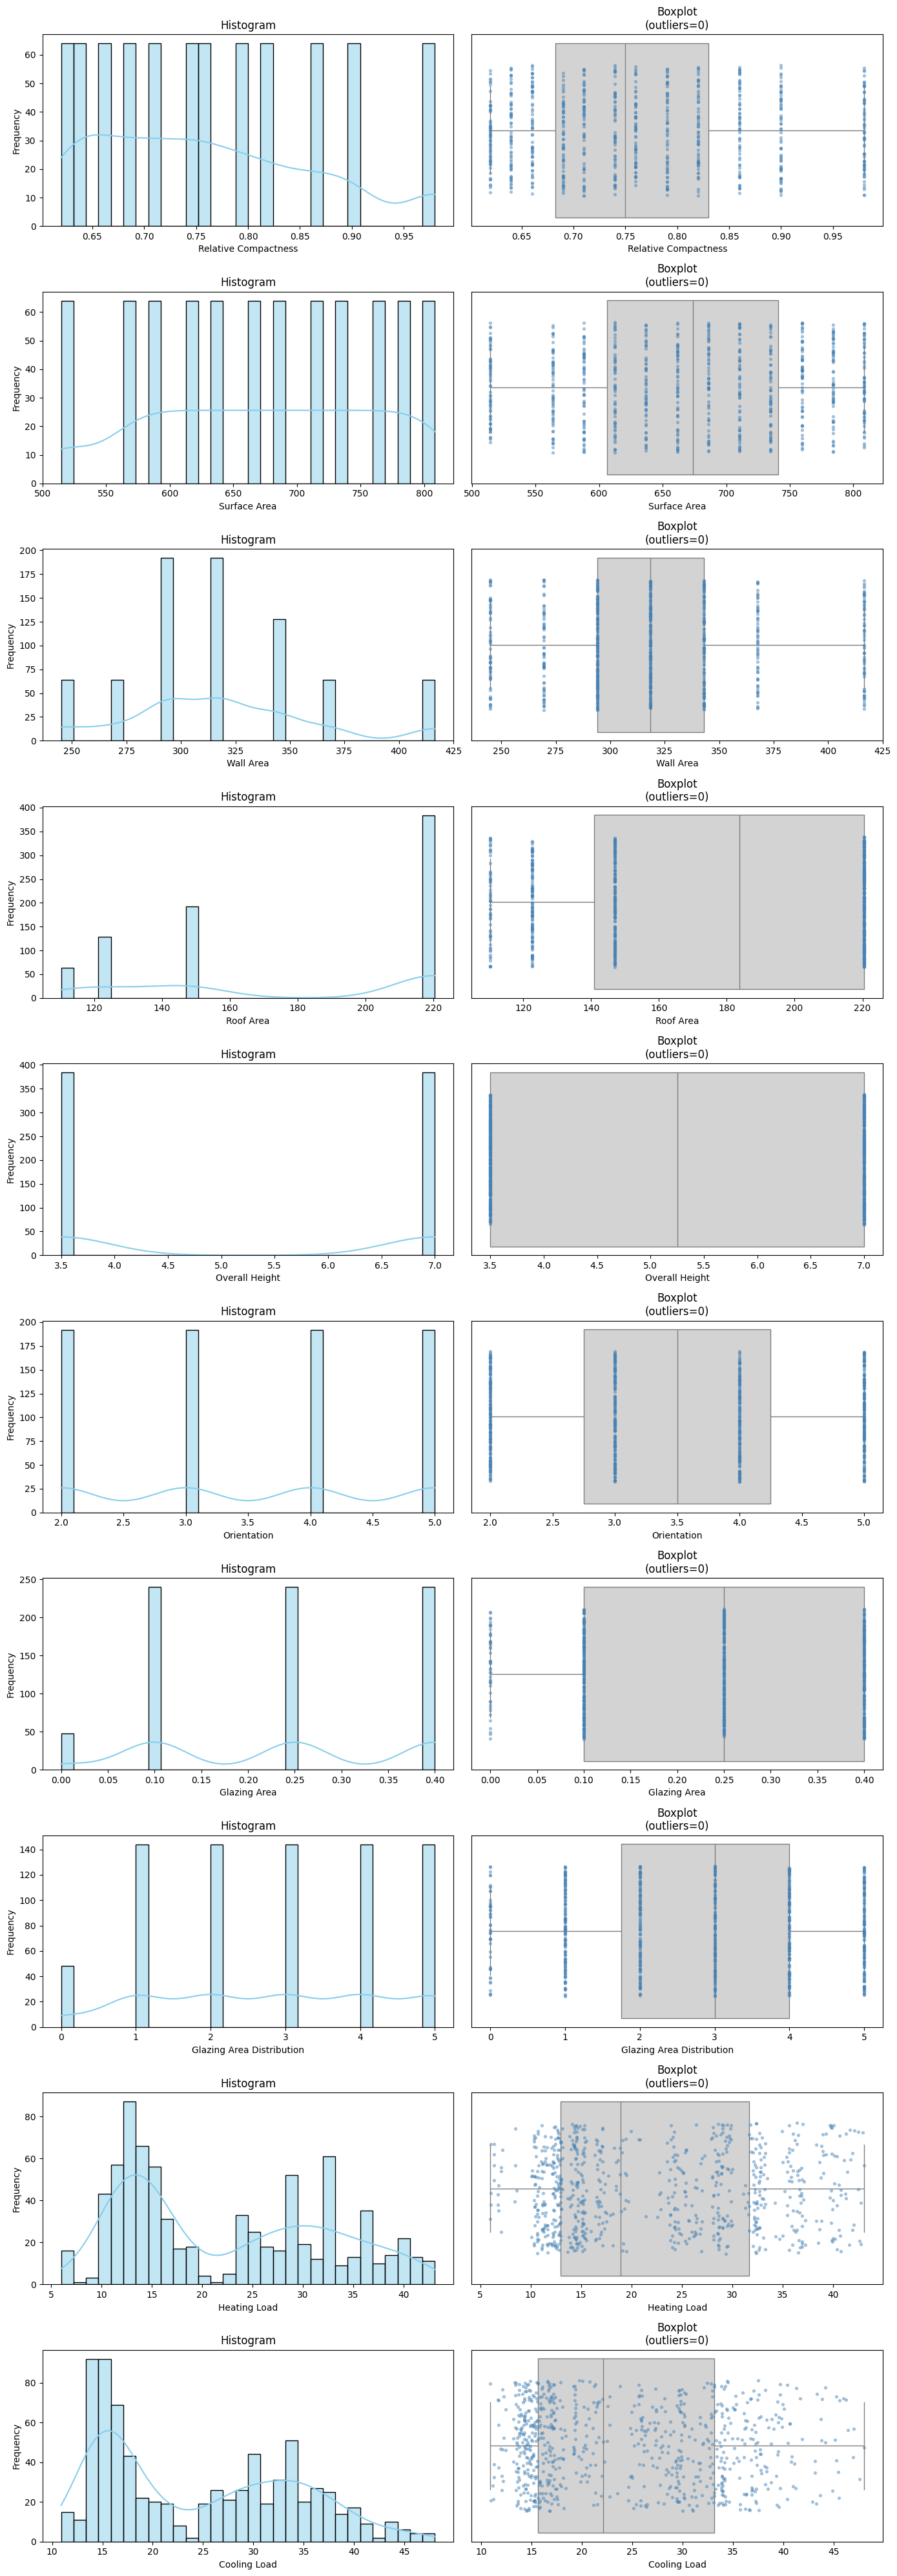

In [13]:
# Zakładamy, że masz już DataFrame df z kolumnami numerycznymi
numeric_df = df.select_dtypes(include="number")
skewness = numeric_df.skew()
 
# Wyznacz outliery IQR
iqr_outlier_counts = {}
outlier_mask_dict = {}
 
for col in numeric_df.columns:
    q1, q3 = numeric_df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (numeric_df[col] < lower) | (numeric_df[col] > upper)
    iqr_outlier_counts[col] = mask.sum()
    outlier_mask_dict[col] = mask
 
# Wykresy
features = numeric_df.columns
n = len(features)
 
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 4 * n))
 
for i, col in enumerate(features):
    data = numeric_df[col]
    skew_val = skewness[col]
    out_count = iqr_outlier_counts[col]
    outlier_mask = outlier_mask_dict[col]
 
    # Histogram
    ax_hist = axes[i, 0]
    sns.histplot(data, kde=True, ax=ax_hist, bins=30, color="skyblue", edgecolor="black")
    ax_hist.set_title(f"Histogram")
    ax_hist.set_xlabel(col)
    ax_hist.set_ylabel("Frequency")
 
    # Boxplot + scatter
    ax_box = axes[i, 1]
    sns.boxplot(x=data, ax=ax_box, color="lightgray", fliersize=0, zorder=1)  # box z tyłu
 
    # Jitter
    jitter = np.random.uniform(low=-0.3, high=0.3, size=len(data))
 
    # Punkty normalne
    ax_box.scatter(
        data[~outlier_mask], jitter[~outlier_mask],
        color="steelblue", alpha=0.4, s=8, zorder=2
    )
 
    # Punkty odstające
    ax_box.scatter(
        data[outlier_mask], jitter[outlier_mask],
        color="red", alpha=0.8, s=12, zorder=3
    )
 
    ax_box.set_title(f"Boxplot\n(outliers={out_count})")
    ax_box.set_xlabel(col)
    ax_box.set_yticks([])
 
plt.tight_layout()
plt.show()

## 4. Outlier & Missing-Value Analysis

- Identification of outliers using summary rules (e.g., values beyond 1.5× IQR or Z-scores greater than `threshold`). For example, "Feature X has 5 outliers beyond 1.5× IQR."
- A discussion of whether to cap, transform, drop them, or leave them as they are. For instance, "Outliers in Feature Y will be capped at the 99th percentile."
- A plan for missing-data handling: which columns to impute (mean, median, KNN), which to drop entirely, and any domain-specific logic (e.g., missing means "unknown").
- A short risk assessment: "Dropping rows will reduce n by 10%; imputing may bias Feature Y."

In [ ]:
# There is no outliers or missing-values

## 5. Correlation Analysis

- Create a correlation matrix heatmap to visualize pairwise linear relationships among numeric features and the target variable. If the data distribution is far from normal, use Spearman or Kendall correlation methods instead of Pearson.
  - Example: "Feature A and Feature B have a correlation of 0.95, indicating potential multicollinearity."
- Highlight features with strong correlations that might indicate redundancy or multicollinearity concerns. Discuss whether these features should be removed or transformed.
- Discuss any surprising relationships. For instance, "Feature Y and Feature Z are highly correlated despite no obvious domain link."
- Provide guidance on potential feature selection or dimensionality reduction steps. For example:
  - "Features with correlations above 0.8 will be considered for removal to avoid multicollinearity."
  - "Principal Component Analysis (PCA) may be applied to reduce dimensionality while retaining most of the variance."

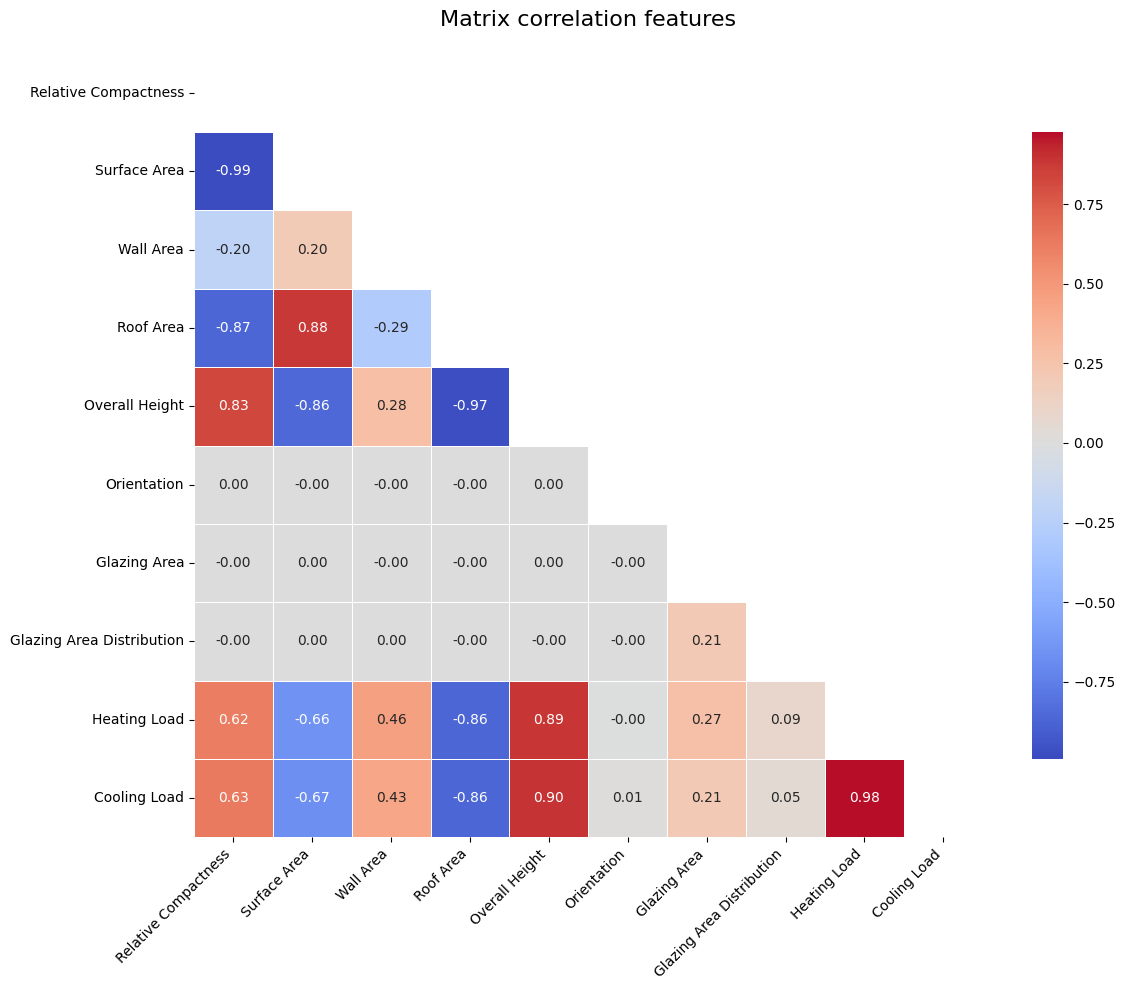

In [14]:
corr_matrix = df.corr(numeric_only=True)
 
use_mask = True
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) if use_mask else None
 
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",  
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
 
plt.title("Matrix correlation features", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# Print max corr between features (excluding target variable)
corr_matrix = df.drop(columns=["Heating Load", "Cooling Load"]).corr().abs()
np.fill_diagonal(corr_matrix.values, 0)
print(corr_matrix.values.max())

0.9919014616138861


In [19]:
# Calculate VIF to double check for multicollinearity concerns
X = df.drop(columns=["Heating Load", "Cooling Load"])
X_const = add_constant(X)
 
# Compute VIF for each feature
vif_data = pd.DataFrame({
    "feature": X_const.columns,
    "VIF": [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]})
 
vif_data = vif_data[vif_data.feature != "const"].reset_index(drop=True)
display(vif_data)

c:\Users\kowna\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Relative Compactness,105.524054
1,Surface Area,inf
2,Wall Area,inf
3,Roof Area,inf
4,Overall Height,31.205474
5,Orientation,1.000000
6,Glazing Area,1.047508
7,Glazing Area Distribution,1.047508


## 6. Multivariate Exploration

- A description of pairwise scatter patterns among top-correlated features and with the target—what shapes (linear, curved, clusters) you see. For example, 
  - "Feature A and Feature B show a linear relationship with some clustering."
  - "Feature X has a strong positive correlation with the target, suggesting it may be a good predictor."
- Insights from a low-dimensional projection (like PCA): whether data forms distinct groups, follows a simple manifold, or exhibits strange clustering. Consider using pair plots or PCA visualizations.
- Any interaction effects you note (e.g., "Feature A only matters when Feature B is high").
- Optional thoughts on unsupervised patterns (e.g., k-means segments) if they seem relevant to downstream stratification or modeling.

In [24]:
df_without_y2 = df.drop(columns="Cooling Load")
corr_with_target = df_without_y2.corr()["Heating Load"].abs().sort_values(ascending=False)
top_feats = corr_with_target.index[1:5]   # skip “target” itself
print("Top features by |corr| to target:", list(top_feats))

Top features by |corr| to target: ['Overall Height', 'Roof Area', 'Surface Area', 'Relative Compactness']


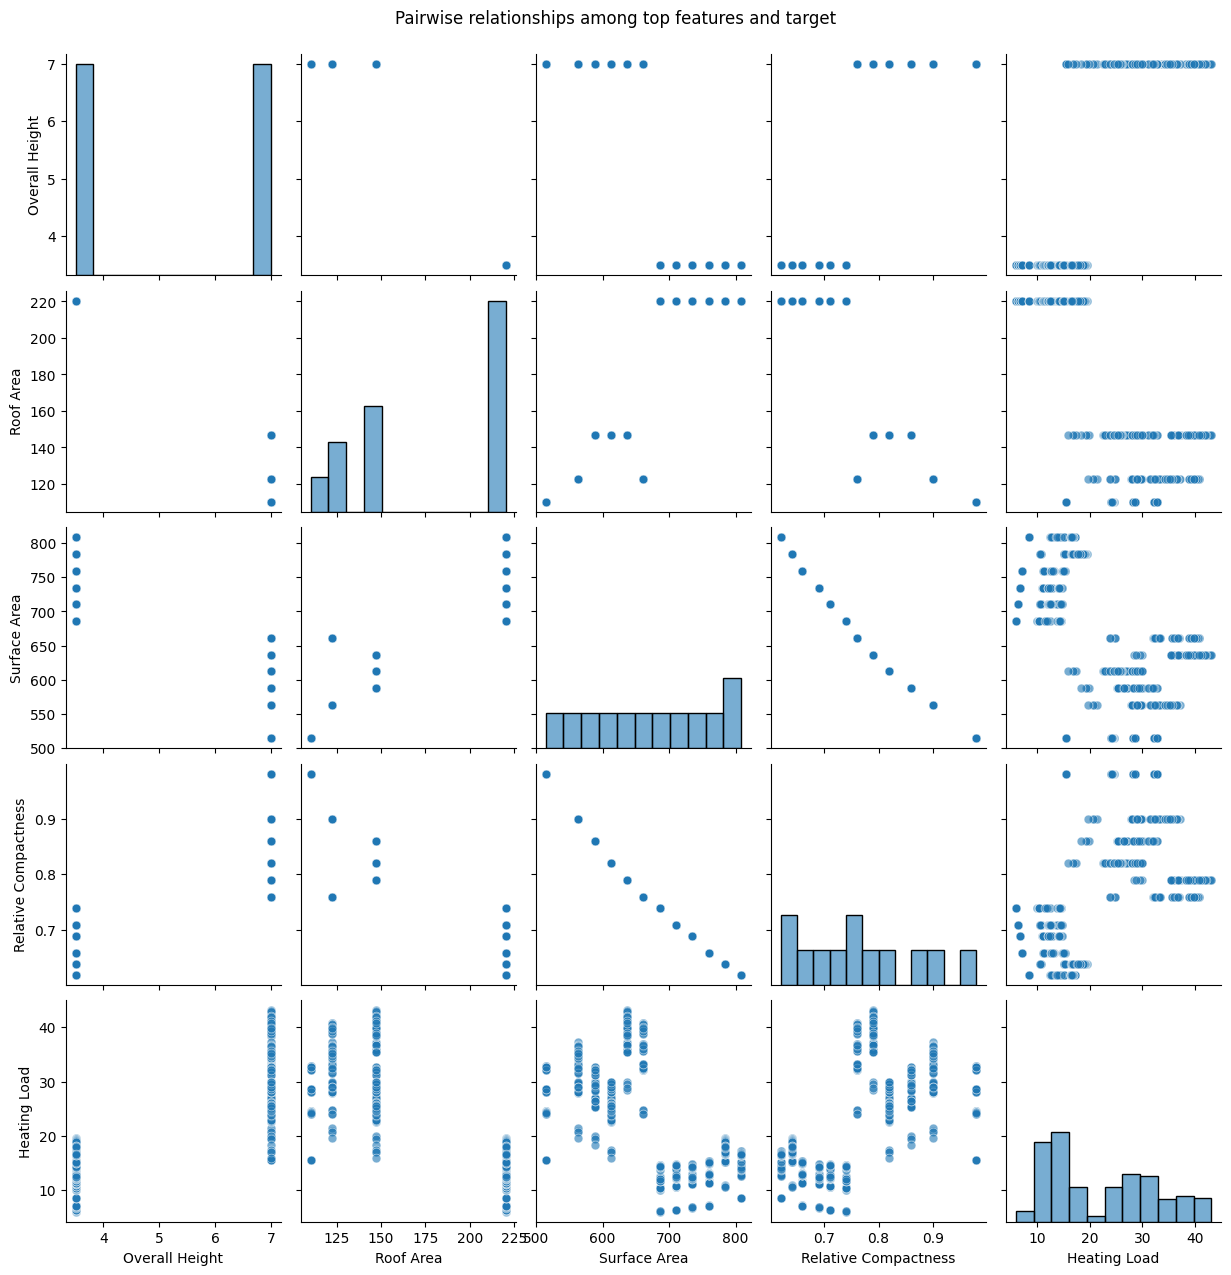

In [28]:
sns.pairplot(
    df_without_y2[list(top_feats) + ["Heating Load"]],
    kind="scatter",
    diag_kind="hist",
    plot_kws={"alpha":0.6, "s":40, "edgecolor":"white"},
    diag_kws={"alpha":0.6})
 
plt.suptitle("Pairwise relationships among top features and target", y=1.02)
plt.show()

In [30]:
correlation = df_without_y2.corr(numeric_only=True)["Heating Load"].abs().drop("Heating Load")
selected_corr = correlation[correlation >= 0.2].index.tolist()
print("Features after correlation filter:", selected_corr)
 
X = df_without_y2[selected_corr]
y = df_without_y2["Heating Load"]
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED)
 
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)
 
lasso = LassoCV(cv=5, n_alphas=100, random_state=SEED).fit(X_train_scaled, y_train)
lasso_coefs = pd.Series(lasso.coef_, index=selected_corr)
lasso_selected = lasso_coefs[lasso_coefs != 0].index.tolist()
print("\nFeatures selected by LassoCV:", lasso_selected)
 
rf = RandomForestRegressor(n_estimators=100, random_state=SEED).fit(X_train, y_train)
perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=SEED)
perm_scores = pd.Series(perm_result.importances_mean, index=selected_corr).sort_values(ascending=False)
print("\nPermutation importances (RF):\n",perm_scores)
 
final_features = list(set(lasso_selected) & set(perm_scores[perm_scores > 0].index))
print("\nFinal selected features (Lasso ∩ Permutation):", final_features)

Features after correlation filter: ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area']

Features selected by LassoCV: ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Glazing Area']

Permutation importances (RF):
 Relative Compactness    0.231317
Glazing Area            0.153002
Surface Area            0.116855
Overall Height          0.085972
Roof Area               0.081213
Wall Area               0.040902
dtype: float64

Final selected features (Lasso ∩ Permutation): ['Wall Area', 'Relative Compactness', 'Roof Area', 'Surface Area', 'Overall Height', 'Glazing Area']


In [31]:
X_all = df_without_y2.drop(columns="Heating Load")
y = df_without_y2["Heating Load"]
 
correlation = X_all.corrwith(y).abs()
low_corr_features = correlation[correlation < 0.2].index.tolist()
print("Low-correlation features (|corr| < 0.2):")
print(low_corr_features)
 
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42)
 
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)
 
lasso = LassoCV(cv=5, random_state=0).fit(X_train_s, y_train)
lasso_coefs = pd.Series(lasso.coef_, index=X_all.columns)
selected_lasso = lasso_coefs[lasso_coefs != 0].index.tolist()
 
print("\nFeatures selected by LassoCV:")
print(selected_lasso)
 
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)
perm_scores = pd.Series(perm_result.importances_mean, index=X_all.columns).sort_values(ascending=False)
selected_perm = perm_scores[perm_scores > 0].index.tolist()
 
print("\nFeatures with positive permutation importance (RF):")
print(selected_perm)
 
kept_lasso  = [f for f in low_corr_features if f in selected_lasso]
dropped_lasso = [f for f in low_corr_features if f not in selected_lasso]
 
kept_perm  = [f for f in low_corr_features if f in selected_perm]
dropped_perm = [f for f in low_corr_features if f not in selected_perm]
 
print("\nLow-correlation features kept by LassoCV:")
print(kept_lasso or "None")
 
print("\nLow-correlation features dropped by LassoCV:")
print(dropped_lasso or "None")
 
print("\nLow-correlation features kept by RF permutation importance:")
print(kept_perm or "None")
 
print("\nLow-correlation features dropped by RF permutation importance:")
print(dropped_perm or "None")
 
dropped_by_both = list(set(dropped_lasso) & set(dropped_perm))
 
print("\nLow-correlation features dropped by BOTH LassoCV and RF permutation importance:")
print(dropped_by_both if dropped_by_both else "None")

Low-correlation features (|corr| < 0.2):
['Orientation', 'Glazing Area Distribution']

Features selected by LassoCV:
['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']

Features with positive permutation importance (RF):
['Relative Compactness', 'Glazing Area', 'Surface Area', 'Roof Area', 'Overall Height', 'Wall Area', 'Glazing Area Distribution', 'Orientation']

Low-correlation features kept by LassoCV:
['Orientation', 'Glazing Area Distribution']

Low-correlation features dropped by LassoCV:
None

Low-correlation features kept by RF permutation importance:
['Orientation', 'Glazing Area Distribution']

Low-correlation features dropped by RF permutation importance:
None

Low-correlation features dropped by BOTH LassoCV and RF permutation importance:
None


## 7. Feature Engineering Plan

- A bullet list of transformations you intend to apply: log or power transforms for skewed distributions, scaling or normalization for models that require it.
- Ideas for derived features: interactions, polynomial terms, binning of continuous variables, or aggregations if relevant.
- Notes on how to encode categorical variables (one-hot, ordinal) and any thresholds (e.g., group rare categories under "Other").
- A rationale for each choice—how it might help bagging, boosting, or stacking models.
- Validate the effectiveness of engineered features by checking feature importance scores or model performance after training.

1. No need for extra features - every relationship that is present is linear.
2. Drop `Cooling Load`, `Surface Area`, `Overall Height`

## 8. Preprocessing Pipeline Outline

- Short, step-by-step list of the operations in the order they should run in pipeline:
  1. Missing-value imputation
  2. Outlier capping or removal (and optional imputation of removed outliers)
  3. Feature transforms and scaling
  4. Train/test split configuration -- only if data analysis suggests that specific train/test split could be beneficial / is mandatory (for example time series data)

## Is Scaling Needed?

### Boosting
- **Tree-based methods** (`XGBoost`, `LightGBM`, `CatBoost`) are invariant to monotonic transformations - no scaling needed.
- **Gradient-descent models** (e.g., `AdaBoost` with linear or NN base learners) - scaling helps with convergence and regularization.

### Bagging
- **Tree ensembles** (`RandomForest`, `Bagged Trees`) - no scaling needed.
- **Distance/kernel-based models** (`KNN`, `SVM`, `RBF`) - scaling is important so no feature dominates.

### Stacking
- **Base models** - scale if needed (e.g., linear, `SVM`, `NN`, `KNN`); skip for trees.
- **Meta-learner** - operates on base model predictions — usually no scaling needed unless outputs differ in scale.

## Missing-value and outlier
There is no missing-values and outliers.